In [164]:
import sys
import os

try:
    sys.path.append(os.path.join(os.path.dirname(__file__), '../'))
except:
    sys.path.append(os.path.join(os.getcwd(), '../'))
    
import re

import pandas as pd
from src import data, models

from scipy.stats import chi2_contingency
from scipy.stats import chi2, ttest_ind

pd.options.display.max_colwidth = -1

/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [165]:
words = {}

In [166]:
df = pd.read_csv('../data/raw/Hate-speech-dataset/hate_speech.tsv', sep='\t',header=None,usecols=[0,1])
df = df.dropna()
df.columns = ['text','category']

print(df.category.value_counts(normalize=True))
df['text_len'] = df.text.apply(lambda x: len(x.split()))
print (df.shape[0], int(df.shape[0]*.8) ,int(df.shape[0]*.1) )
print(df['text_len'].describe())
num_words = len(set(" ".join(df.text.values.tolist()).split()))
words['hate_speech'] = set(" ".join(df.text.values.tolist()).split())
print(num_words)

print (df[(df.text_len >= 5) & (df.text_len <= 15)].head(20))

no     0.636522
yes    0.362604
n      0.000437
on     0.000437
Name: category, dtype: float64
4578 3662 457
count    4578.000000
mean     19.993884  
std      10.382859  
min      1.000000   
25%      12.000000  
50%      19.000000  
75%      25.000000  
max      67.000000  
Name: text_len, dtype: float64
20268
                                                                                                                                          text  \
5   Hate it jab test ata ho phr bh acha na ho -.-                                                                                                
12  Ha rem  "" emoji I hate this emoji! Mujhe nagini ki hi yaad aati Hai                                                                         
14  Sir apki fav kon hai iss seasn mai??                                                                                                         
20  Arsi bahar jani chahiye.... I hate arsi khan                                                      

In [174]:
temp = df.assign(var1=df['text'].str.split(' ')).explode('var1')
for col in temp['category'].unique():
    print (col, temp[temp.category == col].var1.value_counts().head(15))

no hai     1318
rape    1293
ki      821 
ka      814 
ko      791 
ke      734 
se      641 
to      637 
hate    560 
ho      553 
bhi     515 
me      497 
aur     483 
nahi    478 
        473 
Name: var1, dtype: int64
yes hai     786
rape    697
ki      624
hate    603
ko      526
ka      472
ke      450
se      447
to      384
        379
bhi     345
ho      323
aur     302
k       291
I       281
Name: var1, dtype: int64
n 6yrs                              1
via                               1
Se                                1
Episode                           1
Tum                               1
http://youtu.be/YZhoKqh0VU8?a     1
Pal                               1
Mohabbat                          1
nikah                             1
18                                1
2017                              1
me                                1
Geo:                              1
Har                               1
@YouTube                          1
Name: var1, dtype: int64
o

In [150]:
df = pd.read_csv('../data/processed/Aggression_dataset/train.txt', sep='\t',header=None,usecols=[0,1])
df = df.dropna()
df.columns = ['text','category']

df_ = pd.read_csv('../data/processed/Aggression_dataset/val.txt', sep='\t',header=None,usecols=[0,1])
df_ = df_.dropna()
df_.columns = ['text','category']

df = pd.concat([df,df_],axis=0)

print(df.category.value_counts(normalize=True))
df['text_len'] = df.text.apply(lambda x: len(x.split()))
print (df.shape[0], int(df.shape[0]*.8) ,int(df.shape[0]*.1) )
print(df['text_len'].describe())
num_words = len(set(" ".join(df.text.values.tolist()).split()))
words['aggression'] = set(" ".join(df.text.values.tolist()).split())
print(num_words)

print (df[(df.text_len >= 5) & (df.text_len <= 15)].head(20))
print (df[df.category == 'NAG'].tail(10))

CAG    0.3804
OAG    0.3164
NAG    0.3032
Name: category, dtype: float64
30000 24000 3000
count    30000.000000
mean     26.086167   
std      39.924125   
min      1.000000    
25%      11.000000   
50%      16.000000   
75%      28.000000   
max      1126.000000 
Name: text_len, dtype: float64
103786
                                                                            text  \
4   UPA walo ne bahot kuch kr diya tha desh k liye                                 
11  विदिशा से बीजेपी की सुषमा स्वराज आगे                                           
12  Bhaii tume lagta bjp ne kia h ye to fir aao politics me sudharo society.....   
13  Es kutte ko jail me daal do .Desh drohi hai                                    
20  Is gadhe ke gand main itna bambu dalo sala marhi jaye                          
21  Karat has apn bhahin la experience hai. Bikul sahi send kar de hafiz la.       
22  Ravish jii aap ke kasbe Mein sirf congressi rahte hai                          
23  Bole tw zeada kon lo

In [151]:
df = pd.read_csv('../data/processed/humor-detection-corpus/data.txt', sep='\t',header=None,usecols=[0,1])
df = df.dropna()
df.columns = ['text','category']

print(df.category.value_counts(normalize=True))
df['text_len'] = df.text.apply(lambda x: len(x.split()))
print (df.shape[0], int(df.shape[0]*.8) ,int(df.shape[0]*.1) )
print(df['text_len'].describe())
num_words = len(set(" ".join(df.text.values.tolist()).split()))
words['humor'] = set(" ".join(df.text.values.tolist()).split())
print(num_words)

print (df[(df.text_len >= 5) & (df.text_len <= 15)].head(20))

H    0.594512
N    0.402100
n    0.001694
h    0.001355
M    0.000339
Name: category, dtype: float64
2952 2361 295
count    2952.000000
mean     13.314363  
std      6.118182   
min      2.000000   
25%      8.000000   
50%      12.000000  
75%      18.000000  
max      32.000000  
Name: text_len, dtype: float64
12152
                                                                                           text  \
2   Uncle: Isse shaadi huee nahi.. Phir huee nahi..\nSales girl: Aur bachche kitne hai aapke??    
3   .@BabaFirki haan BC yahi baaki reh gaya hai baad mein shahid hone abhi bolega tu              
5   Please follow @SaleemChikna & @sayshardik, ye log free mein daaru pilaate hai. #AaiShappath   
6   .@mannequin_talks sanskaar kaha hai? @aloknath kuch sikaho inhe                               
7   Ye photoshop nahi hota toh 50% twitter ke launde khush hote                                   
8   Kuch bhi chutiya account bana lo, log bahut velle hai.                            

In [152]:
df = pd.read_csv('../data/processed/SarcasmDetection_CodeMixed/data.txt', sep='\t',header=None,usecols=[0,1])
df = df.dropna()
df.columns = ['text','category']

print(df.category.value_counts(normalize=True))
df['text_len'] = df.text.apply(lambda x: len(x.split()))
print (df.shape[0], int(df.shape[0]*.8) ,int(df.shape[0]*.1) )
print(df['text_len'].describe())
num_words = len(set(" ".join(df.text.values.tolist()).split()))
words['sarcasm'] = set(" ".join(df.text.values.tolist()).split())
print(num_words)

print (df[(df.text_len >= 5) & (df.text_len <= 15)].head(20))

NO     0.904
YES    0.096
Name: category, dtype: float64
5250 4200 525
count    5250.000000
mean     19.231810  
std      6.171285   
min      1.000000   
25%      15.000000  
50%      20.000000  
75%      24.000000  
max      33.000000  
Name: text_len, dtype: float64
23813
                                                                                                                                           text  \
0   Triple Talaq par Burbak Kuchh nahi bolega                                                                                                     
6   Sohail bahi hame bhi treen kardo muje bhi shock he cricket                                                                                    
9   #@spn_cricket lijiye S Thakur ne phir pahni no.10 jarsi, inka kharab din chalu ho gaya..@BCCI#Slsvind                                         
11  #Bollywood @amitdey10510709   Bhaag Milkha Bhaag!                                                                                   

In [153]:
df = pd.read_csv('../data/processed/StanceDetection_CodeMixed/data.txt', sep='\t',header=None,usecols=[0,1])
df = df.dropna()
df.columns = ['text','category']

print(df.category.value_counts(normalize=True))
df['text_len'] = df.text.apply(lambda x: len(x.split()))
print (df.shape[0], int(df.shape[0]*.8) ,int(df.shape[0]*.1) )
print(df['text_len'].describe())
num_words = len(set(" ".join(df.text.values.tolist()).split()))
words['stance'] = set(" ".join(df.text.values.tolist()).split())
print(num_words)

print (df[(df.text_len >= 5) & (df.text_len <= 15)].head(20))

NONE       0.545557
FAVOR      0.271932
AGAINST    0.182511
Name: category, dtype: float64
3545 2836 354
count    3545.000000
mean     18.539915  
std      6.018515   
min      2.000000   
25%      14.000000  
50%      19.000000  
75%      23.000000  
max      32.000000  
Name: text_len, dtype: float64
15390
                                                                                                                                text  \
2   #ByeByeBlackmoney. Notebandi, Ghoosbandi and Nasbandi door kar degi desh ki gandagi.                                               
3   Jaise notebandi nahi unki nasbandi kardi ho Modiji ne  https://twitter.com/anuraagmuskaan/status/796740961560772609 …              
12  #IndiraGandhi barbeed hui NASBANDI karwa ke  #MODI barbaad ho raha hai #notebandi karwa ke                                         
13  Ye rumour vhi failla rhe hain jinhe 1000-500 notebandi se pareshan hain. https://twitter.com/raydeep/status/797111187615858690 …   
17  Noteba

In [8]:
for key1, val1 in words.items():
    for key2, val2 in words.items():
        if key1 != key2:
            print (key1, key2, len(val1.intersection(val2))*1.0/len(val1))

hate_speech aggression 0.4957568581014407
hate_speech humor 0.1923228734951648
hate_speech sarcasm 0.3406354845075982
hate_speech stance 0.23554371422932702
aggression hate_speech 0.09681459927157805
aggression humor 0.05669358102248858
aggression sarcasm 0.09896325130557108
aggression stance 0.06852562002582237
humor hate_speech 0.3207702435813035
humor aggression 0.48420013166556947
humor sarcasm 0.36043449637919683
humor stance 0.2564186965108624
sarcasm hate_speech 0.2899256708520556
sarcasm aggression 0.4313190274219964
sarcasm humor 0.18393314576071892
sarcasm stance 0.21660437576113886
stance hate_speech 0.3102014294996751
stance aggression 0.4621182586094867
stance humor 0.20246913580246914
stance sarcasm 0.33515269655620533


In [9]:
def calculate_lift(df,col1='category',col2='category_predicted_model2'):
    for val1 in df[col1].unique():
        for val2 in df[col2].unique():
            support = df[(df[col1] == val1) & (df[col2] == val2)].shape[0]/df.shape[0]
            confidence = support*df.shape[0]/df[df[col2] == val2].shape[0]
            lift = confidence*df.shape[0]/df[df[col1] == val1].shape[0]
            
            print ("Lift of {} => {} is {}".format(val1,val2,lift))

In [10]:
hate_test = pd.read_csv('../models/hate_detection/full_test.csv',sep='\t')

In [11]:
hate_test.head()

,text,category,type,category_predicted_model1,category_prob_model1,category_predicted_model2,category_prob_model2
0,doctor sab sahi me ke phd (in hate politics) ...,no,hate,no,1.000000,no,0.999984
1,poore desh me patel obc me aate hain sirf gujr...,no,hate,no,0.999994,no,0.993172
2,hate it jab test ata ho phr bh acha na ho -.-,yes,hate,yes,0.999999,yes,0.998417
3,ek dil ek jaan akal ke imitihaan kal kp ke rap...,no,hate,no,0.999999,no,0.915283
4,aise logo se sakht nafrat karta hu jo caste ko...,yes,hate,yes,1.000000,yes,0.999865


In [12]:
_, p, _, _ = chi2_contingency(pd.crosstab(hate_test[hate_test['type'] == 'aggression']['category'],\
            hate_test[hate_test['type'] == 'aggression']['category_predicted_model2']).values)

print (p)

3.252024298636947e-07


In [13]:
hate_test[hate_test['type'] == 'aggression'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
CAG       no                           0.884984
          yes                          0.115016
NAG       no                           0.946333
          yes                          0.053667
OAG       no                           0.857023
          yes                          0.142977
Name: category_predicted_model2, dtype: float64

In [14]:
calculate_lift(hate_test[hate_test['type'] == 'aggression'])

Lift of OAG => yes is 1.2468949869931738
Lift of OAG => no is 0.9680226372267876
Lift of CAG => yes is 1.0030462887287317
Lift of CAG => no is 0.9996054505562185
Lift of NAG => yes is 0.4680284561301328
Lift of NAG => no is 1.0688999288747116


In [15]:
_, p, _, _ = chi2_contingency(pd.crosstab(hate_test[hate_test['type'] == 'humor']['category'],\
            hate_test[hate_test['type'] == 'humor']['category_predicted_model2']).values)

print (p)

0.9380758044926549


In [16]:
hate_test[hate_test['type'] == 'humor'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
H         no                           0.926136
          yes                          0.073864
N         no                           0.916667
          yes                          0.083333
Name: category_predicted_model2, dtype: float64

In [17]:
calculate_lift(hate_test[hate_test['type'] == 'humor'])

Lift of H => no is 1.0041625041625042
Lift of H => yes is 0.950592885375494
Lift of N => no is 0.9938949938949939
Lift of N => yes is 1.072463768115942


In [18]:
_, p, _, _ = chi2_contingency(pd.crosstab(hate_test[hate_test['type'] == 'sarcasm']['category'],\
            hate_test[hate_test['type'] == 'sarcasm']['category_predicted_model2']).values)

print (p)

0.6874626944218479


In [19]:
hate_test[hate_test['type'] == 'sarcasm'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
NO        no                           0.888412
          yes                          0.111588
YES       no                           0.915254
          yes                          0.084746
Name: category_predicted_model2, dtype: float64

In [20]:
calculate_lift(hate_test[hate_test['type'] == 'sarcasm'])

Lift of NO => no is 0.9966160448993067
Lift of NO => yes is 1.0277840524056923
Lift of YES => no is 1.0267275097783573
Lift of YES => yes is 0.7805530776092775


In [21]:
_, p, _, _ = chi2_contingency(pd.crosstab(hate_test[hate_test['type'] == 'stance']['category'],\
            hate_test[hate_test['type'] == 'stance']['category_predicted_model2']).values)

print (p)

0.6602731269338526


In [22]:
hate_test[hate_test['type'] == 'stance'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
AGAINST   no                           0.882353
          yes                          0.117647
FAVOR     no                           0.877193
          yes                          0.122807
NONE      no                           0.908213
          yes                          0.091787
Name: category_predicted_model2, dtype: float64

In [23]:
calculate_lift(hate_test[hate_test['type'] == 'stance'])

Lift of NONE => no is 1.0138850909974781
Lift of NONE => yes is 0.8806632719676197
Lift of FAVOR => no is 0.9792563168928611
Lift of FAVOR => yes is 1.1782835467045993
Lift of AGAINST => no is 0.9850166481687016
Lift of AGAINST => yes is 1.1287758346581875


In [24]:
aggression_test = pd.read_csv('../models/model_aggression/full_test.csv',sep='\t')

In [25]:
_, p, _, _ = chi2_contingency(pd.crosstab(aggression_test[aggression_test['type'] == 'hate']['category'],\
            aggression_test[aggression_test['type'] == 'hate']['category_predicted_model2']).values)

print (p)

0.6126646037670338


In [26]:
aggression_test[aggression_test['type'] == 'hate'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
no        CAG                          0.459119
          OAG                          0.430818
          NAG                          0.110063
yes       OAG                          0.471429
          CAG                          0.442857
          NAG                          0.085714
Name: category_predicted_model2, dtype: float64

In [27]:
calculate_lift(aggression_test[aggression_test['type'] == 'hate'])

Lift of no => OAG is 0.9719924404374631
Lift of no => CAG is 1.0109458151910982
Lift of no => NAG is 1.072527766626522
Lift of yes => OAG is 1.0636171710063336
Lift of yes => CAG is 0.9751373626373628
Lift of yes => NAG is 0.8352583586626139


In [28]:
_, p, _, _ = chi2_contingency(pd.crosstab(aggression_test[aggression_test['type'] == 'humor']['category'],\
            aggression_test[aggression_test['type'] == 'humor']['category_predicted_model2']).values)

print (p)

0.2087935901118099


In [29]:
aggression_test[aggression_test['type'] == 'humor'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
H         CAG                          0.392045
          OAG                          0.386364
          NAG                          0.221591
N         CAG                          0.425000
          OAG                          0.291667
          NAG                          0.283333
Name: category_predicted_model2, dtype: float64

In [30]:
calculate_lift(aggression_test[aggression_test['type'] == 'humor'])

Lift of H => OAG is 1.1103265666372464
Lift of H => NAG is 0.8985056039850559
Lift of H => CAG is 0.9670454545454544
Lift of N => OAG is 0.8381877022653722
Lift of N => NAG is 1.1488584474885846
Lift of N => CAG is 1.0483333333333333


In [31]:
_, p, _, _ = chi2_contingency(pd.crosstab(aggression_test[aggression_test['type'] == 'sarcasm']['category'],\
            aggression_test[aggression_test['type'] == 'sarcasm']['category_predicted_model2']).values)

print (p)

0.07273999330705425


In [32]:
aggression_test[aggression_test['type'] == 'sarcasm'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
NO        CAG                          0.532189
          OAG                          0.336910
          NAG                          0.130901
YES       CAG                          0.559322
          NAG                          0.220339
          OAG                          0.220339
Name: category_predicted_model2, dtype: float64

In [33]:
calculate_lift(aggression_test[aggression_test['type'] == 'sarcasm'])

Lift of NO => CAG is 0.9943029951277627
Lift of NO => OAG is 1.0404569553143146
Lift of NO => NAG is 0.9286915671035842
Lift of YES => CAG is 1.0449966825502142
Lift of YES => OAG is 0.6804586241276172
Lift of YES => NAG is 1.5632157581310127


In [34]:
_, p, _, _ = chi2_contingency(pd.crosstab(aggression_test[aggression_test['type'] == 'stance']['category'],\
            aggression_test[aggression_test['type'] == 'stance']['category_predicted_model2']).values)

print (p)

0.6717344758535984


In [35]:
aggression_test[aggression_test['type'] == 'stance'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
AGAINST   CAG                          0.705882
          OAG                          0.235294
          NAG                          0.058824
FAVOR     CAG                          0.631579
          OAG                          0.280702
          NAG                          0.087719
NONE      CAG                          0.589372
          OAG                          0.294686
          NAG                          0.115942
Name: category_predicted_model2, dtype: float64

In [36]:
calculate_lift(aggression_test[aggression_test['type'] == 'stance'])

Lift of NONE => OAG is 1.0357774907925574
Lift of NONE => CAG is 0.959757124495856
Lift of NONE => NAG is 1.1433172302737518
Lift of FAVOR => OAG is 0.9866249782873024
Lift of FAVOR => CAG is 1.0284886528247223
Lift of FAVOR => NAG is 0.865009746588694
Lift of AGAINST => OAG is 0.8270238788584741
Lift of AGAINST => CAG is 1.1494873178629248
Lift of AGAINST => NAG is 0.5800653594771241


In [37]:
humor_test = pd.read_csv('../models/humor_detection/full_test.csv',sep='\t')

In [38]:
_, p, _, _ = chi2_contingency(pd.crosstab(humor_test[humor_test['type'] == 'hate']['category'],\
            humor_test[humor_test['type'] == 'hate']['category_predicted_model2']).values)

print (p)

0.9977765902751704


In [39]:
humor_test[humor_test['type'] == 'hate'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
no        H                            0.805031
          N                            0.194969
yes       H                            0.800000
          N                            0.200000
Name: category_predicted_model2, dtype: float64

In [40]:
calculate_lift(humor_test[humor_test['type'] == 'hate'])

Lift of no => N is 0.9921733053808528
Lift of no => H is 1.001914137270987
Lift of yes => N is 1.0177777777777777
Lift of yes => H is 0.9956521739130435


In [41]:
_, p, _, _ = chi2_contingency(pd.crosstab(humor_test[humor_test['type'] == 'sarcasm']['category'],\
            humor_test[humor_test['type'] == 'sarcasm']['category_predicted_model2']).values)

print (p)

0.6536227360236224


In [42]:
humor_test[humor_test['type'] == 'sarcasm'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
NO        H                            0.781116
          N                            0.218884
YES       H                            0.745763
          N                            0.254237
Name: category_predicted_model2, dtype: float64

In [43]:
calculate_lift(humor_test[humor_test['type'] == 'sarcasm'])

Lift of NO => N is 0.9821723341036646
Lift of NO => H is 1.0051123453673316
Lift of YES => N is 1.1408083441981747
Lift of YES => H is 0.9596211365902293


In [44]:
_, p, _, _ = chi2_contingency(pd.crosstab(humor_test[humor_test['type'] == 'aggression']['category'],\
            humor_test[humor_test['type'] == 'aggression']['category_predicted_model2']).values)

print (p)

9.44501359285401e-16


In [45]:
humor_test[humor_test['type'] == 'aggression'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
CAG       H                            0.542332
          N                            0.457668
NAG       N                            0.633274
          H                            0.366726
OAG       H                            0.574432
          N                            0.425568
Name: category_predicted_model2, dtype: float64

In [46]:
calculate_lift(humor_test[humor_test['type'] == 'aggression'])

Lift of OAG => H is 1.0997427492924667
Lift of OAG => N is 0.890930294388489
Lift of CAG => H is 1.038287686733772
Lift of CAG => N is 0.9581320271375987
Lift of NAG => H is 0.7020924638650704
Lift of NAG => N is 1.3257649051803453


In [47]:
_, p, _, _ = chi2_contingency(pd.crosstab(humor_test[humor_test['type'] == 'stance']['category'],\
            humor_test[humor_test['type'] == 'stance']['category_predicted_model2']).values)

print (p)

0.6332394645005726


In [48]:
humor_test[humor_test['type'] == 'stance'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
AGAINST   H                            0.911765
          N                            0.088235
FAVOR     H                            0.859649
          N                            0.140351
NONE      H                            0.850242
          N                            0.149758
Name: category_predicted_model2, dtype: float64

In [49]:
calculate_lift(humor_test[humor_test['type'] == 'stance'])

Lift of NONE => H is 0.9896254058762969
Lift of NONE => N is 1.0632850241545893
Lift of FAVOR => H is 1.0005752085130861
Lift of FAVOR => N is 0.9964912280701755
Lift of AGAINST => H is 1.0612343297974927
Lift of AGAINST => N is 0.626470588235294


In [50]:
sarcasm_test = pd.read_csv('../models/sarcasm_detection/full_test.csv',sep='\t')

In [51]:
_, p, _, _ = chi2_contingency(pd.crosstab(sarcasm_test[sarcasm_test['type'] == 'hate']['category'],\
            sarcasm_test[sarcasm_test['type'] == 'hate']['category_predicted_model2']).values)

print (p)

0.08465996464967636


In [52]:
sarcasm_test[sarcasm_test['type'] == 'hate'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
no        NO                           0.528302
          YES                          0.471698
yes       YES                          0.564286
          NO                           0.435714
Name: category_predicted_model2, dtype: float64

In [53]:
calculate_lift(sarcasm_test[sarcasm_test['type'] == 'hate'])

Lift of no => NO is 1.0566037735849056
Lift of no => YES is 0.9433962264150944
Lift of yes => NO is 0.8714285714285714
Lift of yes => YES is 1.1285714285714286


In [54]:
_, p, _, _ = chi2_contingency(pd.crosstab(sarcasm_test[sarcasm_test['type'] == 'humor']['category'],\
            sarcasm_test[sarcasm_test['type'] == 'humor']['category_predicted_model2']).values)

print (p)

0.1806861896596051


In [55]:
sarcasm_test[sarcasm_test['type'] == 'humor'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
H         NO                           0.505682
          YES                          0.494318
N         NO                           0.591667
          YES                          0.408333
Name: category_predicted_model2, dtype: float64

In [56]:
calculate_lift(sarcasm_test[sarcasm_test['type'] == 'humor'])

Lift of H => NO is 0.9355113636363637
Lift of H => YES is 1.0758689839572193
Lift of N => NO is 1.0945833333333332
Lift of N => YES is 0.8887254901960784


In [57]:
_, p, _, _ = chi2_contingency(pd.crosstab(sarcasm_test[sarcasm_test['type'] == 'aggression']['category'],\
            sarcasm_test[sarcasm_test['type'] == 'aggression']['category_predicted_model2']).values)

print (p)

3.540313521137108e-08


In [58]:
sarcasm_test[sarcasm_test['type'] == 'aggression'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
CAG       NO                           0.547125
          YES                          0.452875
NAG       NO                           0.681574
          YES                          0.318426
OAG       NO                           0.544155
          YES                          0.455845
Name: category_predicted_model2, dtype: float64

In [59]:
calculate_lift(sarcasm_test[sarcasm_test['type'] == 'aggression'])

Lift of OAG => YES is 1.062576335915276
Lift of OAG => NO is 0.9529855549778398
Lift of CAG => YES is 1.0556536115641548
Lift of CAG => NO is 0.9581866911365633
Lift of NAG => YES is 0.7422511894783809
Lift of NAG => NO is 1.1936501571169431


In [60]:
_, p, _, _ = chi2_contingency(pd.crosstab(sarcasm_test[sarcasm_test['type'] == 'stance']['category'],\
            sarcasm_test[sarcasm_test['type'] == 'stance']['category_predicted_model2']).values)

print (p)

0.024521396586768628


In [61]:
sarcasm_test[sarcasm_test['type'] == 'stance'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)

category  category_predicted_model2
AGAINST   NO                           0.676471
          YES                          0.323529
FAVOR     YES                          0.587719
          NO                           0.412281
NONE      YES                          0.541063
          NO                           0.458937
Name: category_predicted_model2, dtype: float64

In [62]:
calculate_lift(sarcasm_test[sarcasm_test['type'] == 'stance'])

Lift of NONE => NO is 0.9874103352364221
Lift of NONE => YES is 1.010933129926265
Lift of FAVOR => NO is 0.8870281765018607
Lift of FAVOR => YES is 1.098107109879963
Lift of AGAINST => NO is 1.4554367201426026
Lift of AGAINST => YES is 0.6044891640866874


In [63]:
stance_test = pd.read_csv('../models/stance_detection/full_test.csv',sep='\t')

In [64]:
_, p, _, _ = chi2_contingency(pd.crosstab(stance_test[stance_test['type'] == 'hate']['category'],\
            stance_test[stance_test['type'] == 'hate']['category_predicted_model2']).values)

print (p)

0.46118105240535157


In [65]:
stance_test[stance_test['type'] == 'hate'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)


category  category_predicted_model2
no        NONE                         0.827044
          FAVOR                        0.113208
          AGAINST                      0.059748
yes       NONE                         0.778571
          FAVOR                        0.150000
          AGAINST                      0.071429
Name: category_predicted_model2, dtype: float64

In [66]:
calculate_lift(stance_test[stance_test['type'] == 'hate'])

Lift of no => FAVOR is 0.9096325719960278
Lift of no => NONE is 1.0182423750591736
Lift of no => AGAINST is 0.943613099110822
Lift of yes => FAVOR is 1.2052631578947368
Lift of yes => NONE is 0.9585637480798772
Lift of yes => AGAINST is 1.1280788177339902


In [67]:
_, p, _, _ = chi2_contingency(pd.crosstab(stance_test[stance_test['type'] == 'humor']['category'],\
            stance_test[stance_test['type'] == 'humor']['category_predicted_model2']).values)

print (p)

0.6829030513528049


In [68]:
stance_test[stance_test['type'] == 'humor'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)


category  category_predicted_model2
H         NONE                         0.835227
          FAVOR                        0.090909
          AGAINST                      0.073864
N         NONE                         0.866667
          FAVOR                        0.083333
          AGAINST                      0.050000
Name: category_predicted_model2, dtype: float64

In [69]:
calculate_lift(stance_test[stance_test['type'] == 'humor'])

Lift of H => FAVOR is 1.034965034965035
Lift of H => NONE is 0.9849692140528795
Lift of H => AGAINST is 1.1507177033492824
Lift of N => FAVOR is 0.9487179487179488
Lift of N => NONE is 1.0220451527224437
Lift of N => AGAINST is 0.7789473684210526


In [70]:
_, p, _, _ = chi2_contingency(pd.crosstab(stance_test[stance_test['type'] == 'sarcasm']['category'],\
            stance_test[stance_test['type'] == 'sarcasm']['category_predicted_model2']).values)

print (p)

0.35492852734153824


In [71]:
stance_test[stance_test['type'] == 'sarcasm'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)


category  category_predicted_model2
NO        NONE                         0.821888
          FAVOR                        0.100858
          AGAINST                      0.077253
YES       NONE                         0.745763
          FAVOR                        0.135593
          AGAINST                      0.118644
Name: category_predicted_model2, dtype: float64

In [72]:
calculate_lift(stance_test[stance_test['type'] == 'sarcasm'])

Lift of NO => NONE is 1.0105185393653697
Lift of NO => FAVOR is 0.9627389777604369
Lift of NO => AGAINST is 0.9432079049805371
Lift of YES => NONE is 0.9169213670464018
Lift of YES => FAVOR is 1.2942989214175655
Lift of YES => AGAINST is 1.4485612928655893


In [73]:
_, p, _, _ = chi2_contingency(pd.crosstab(stance_test[stance_test['type'] == 'aggression']['category'],\
            stance_test[stance_test['type'] == 'aggression']['category_predicted_model2']).values)

print (p)

0.10043337355376523


In [74]:
stance_test[stance_test['type'] == 'aggression'].groupby(['category'])['category_predicted_model2'].value_counts(normalize=True)


category  category_predicted_model2
CAG       NONE                         0.823482
          FAVOR                        0.120607
          AGAINST                      0.055911
NAG       NONE                         0.849732
          FAVOR                        0.118068
          AGAINST                      0.032200
OAG       NONE                         0.806560
          FAVOR                        0.139613
          AGAINST                      0.053827
Name: category_predicted_model2, dtype: float64

In [75]:
calculate_lift(stance_test[stance_test['type'] == 'aggression'])

Lift of OAG => NONE is 0.981614768235533
Lift of OAG => FAVOR is 1.0935753545885147
Lift of OAG => AGAINST is 1.0623699703421716
Lift of CAG => NONE is 1.002209851661277
Lift of CAG => FAVOR is 0.9447025750965558
Lift of CAG => AGAINST is 1.1034975617958636
Lift of NAG => NONE is 1.034156182983958
Lift of NAG => FAVOR is 0.9248144532618392
Lift of NAG => AGAINST is 0.6355333772714433


### Top words

In [187]:
words_hate = pd.read_csv('../models/hate_detection/word_weights.csv',sep='\t')
words_aggression = pd.read_csv('../models/model_aggression/word_weights.csv',sep='\t')
words_humor = pd.read_csv('../models/humor_detection/word_weights.csv',sep='\t')
words_sarcasm = pd.read_csv('../models/sarcasm_detection/word_weights.csv',sep='\t')
words_stance = pd.read_csv('../models/stance_detection/word_weights.csv',sep='\t')

In [188]:
words_hate = words_hate.dropna()
words_hate.word = words_hate.word.apply(lambda x: re.sub('[^a-zA-Z0-9]',' ',x).strip())
words_hate = words_hate[words_hate.word != '']
#words_hate.groupby(['word'])['hate_yes'].var().fillna(0).sort_values(ascending=[False])
#print (words_hate.groupby(['word'])['Hate_yes'].var().fillna(0).describe())
#words_hate = words_hate.groupby(['word'])['Hate_yes'].mean().reset_index(drop=False)

In [189]:
words_sarcasm = words_sarcasm.dropna()
words_sarcasm.word = words_sarcasm.word.apply(lambda x: re.sub('[^a-zA-Z0-9]',' ',x).strip())
words_sarcasm = words_sarcasm[words_sarcasm.word != '']
#words_sarcasm.groupby(['word'])['Sarcasm_yes'].var().fillna(0).sort_values(ascending=[False])
#print (words_sarcasm.groupby(['word'])['Sarcasm_yes'].var().fillna(0).describe())
#words_sarcasm = words_sarcasm.groupby(['word'])['Sarcasm_yes'].mean().reset_index(drop=False)

In [190]:
words_humor = words_humor.dropna()
words_humor.word = words_humor.word.apply(lambda x: re.sub('[^a-zA-Z0-9]',' ',x).strip())
words_humor = words_humor[words_humor.word != '']
#words_sarcasm.groupby(['word'])['Sarcasm_yes'].var().fillna(0).sort_values(ascending=[False])
#print (words_humor.groupby(['word'])['Humor_yes'].var().fillna(0).describe())
#words_humor = words_humor.groupby(['word'])['Humor_yes'].mean().reset_index(drop=False)

In [191]:
words_aggression = words_aggression.dropna()
words_aggression.word = words_aggression.word.apply(lambda x: re.sub('[^a-zA-Z0-9]',' ',x).strip())
words_aggression = words_aggression[words_aggression.word != '']
#words_sarcasm.groupby(['word'])['Sarcasm_yes'].var().fillna(0).sort_values(ascending=[False])
#print (words_aggression.groupby(['word'])['OAG'].var().fillna(0).describe())
#print (words_aggression.groupby(['word'])['CAG'].var().fillna(0).describe())
#words_aggression = words_aggression.groupby(['word'])['OAG','CAG'].mean().reset_index(drop=False)

In [192]:
words_stance = words_stance.dropna()
words_stance.word = words_stance.word.apply(lambda x: re.sub('[^a-zA-Z0-9]',' ',x).strip())
words_stance = words_stance[words_stance.word != '']
#words_sarcasm.groupby(['word'])['Sarcasm_yes'].var().fillna(0).sort_values(ascending=[False])
#print (words_stance.groupby(['word'])['Stance_against'].var().fillna(0).describe())
#print (words_stance.groupby(['word'])['Stance_favor'].var().fillna(0).describe())
#words_stance = words_stance.groupby(['word'])['Stance_against','Stance_favor'].mean().reset_index(drop=False)

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [223]:
pd.DataFrame(words_aggression.groupby(['word'])['OAG'])

,0,1
0,a,"61 1.732969e-06 671 -3.038170e-01 948 5.156091e-05 2005 -4.747525e-08 2109 -5.912448e-06 ... 861913 0.000000e+00 863955 -1.130180e-03 865267 1.311302e-06 866152 2.191005e-06 867858 1.764297e-05 Name: OAG, Length: 3390, dtype: float64"
1,a from,"591685 -2.383566e-11 Name: OAG, dtype: float64"
2,a mere,"810170 0.461035 Name: OAG, dtype: float64"
3,a c,"95957 1.768611e-02 108146 -8.492292e-01 111219 1.791203e-02 365974 1.192093e-07 498755 2.963543e-04 Name: OAG, dtype: float64"
4,a dil,"203238 0.000001 Name: OAG, dtype: float64"
...,...,...
57488,zyada,"3221 0.000000e+00 4560 1.564026e-04 8819 -2.258519e-13 12380 8.078101e-01 13834 1.559627e-02 ... 809487 8.413537e-11 809890 -1.349367e-01 819508 1.814041e-01 830862 1.311302e-06 860771 9.944259e-01 Name: OAG, Length: 147, dtype: float64"
57489,zyadatar,"224086 -0.000008 788789 0.321916 Name: OAG, dtype: float64"
57490,zyadatr,"630168 -2.677656e-08 Name: OAG, dtype: float64"
57491,zyadha,"175604 3.542798e-11 Name: OAG, dtype: float64"


In [251]:
var_tables = pd.DataFrame()

temp = words_aggression[['word','OAG']] #pd.DataFrame(words_aggression.groupby(['word'])['OAG'].var().dropna().reset_index(drop=True))
temp.columns = ['word','score']
temp['Label'] = "OAG"
temp["task"] = "Aggression"

var_tables = pd.concat([var_tables, temp], axis=0)

temp = temp = words_aggression[['word','CAG']] #pd.DataFrame(words_aggression.groupby(['word'])['CAG'].var().dropna().reset_index(drop=True))
temp.columns = ['word','score']
temp['Label'] = "CAG"
temp["task"] = "Aggression"

var_tables = pd.concat([var_tables, temp], axis=0)

temp = temp = words_hate[['word','Hate_yes']] #pd.DataFrame(words_hate.groupby(['word'])['Hate_yes'].var().dropna().reset_index(drop=True))
temp.columns = ['word','score']
temp['Label'] = "Hate"
temp['task'] = "Hate"

var_tables = pd.concat([var_tables, temp], axis=0)

temp = words_humor[['word','Humor_yes']]#pd.DataFrame(words_humor.groupby(['word'])['Humor_yes'].var().dropna().reset_index(drop=True))
temp.columns = ['word','score'] 
temp['Label'] = "Humor"
temp["task"] = "Humor"

var_tables = pd.concat([var_tables, temp], axis=0)

temp = words_sarcasm[['word','Sarcasm_yes']] #pd.DataFrame(words_sarcasm.groupby(['word'])['Sarcasm_yes'].var().dropna().reset_index(drop=True))
temp.columns = ['word','score']
temp['Label'] = "Sarcasm"
temp['task'] = "Sarcasm"

var_tables = pd.concat([var_tables, temp], axis=0)

temp = words_stance[['word','Stance_against']] #pd.DataFrame(words_stance.groupby(['word'])['Stance_against'].var().dropna().reset_index(drop=True))
temp.columns = ['word','score']
temp['Label'] = "Against"
temp["task"] = "Stance"

var_tables = pd.concat([var_tables, temp], axis=0)

temp = words_stance[['word','Stance_favor']] #pd.DataFrame(words_stance.groupby(['word'])['Stance_favor'].var().dropna().reset_index(drop=True))
temp.columns = ['word','score']
temp['Label'] = "Favor"
temp["task"] = "Stance"

var_tables = pd.concat([var_tables, temp], axis=0)

#var_tables.score = np.exp2(var_tables.score)
var_tables = var_tables[(var_tables.score < -.25) | (var_tables.score > .25)]

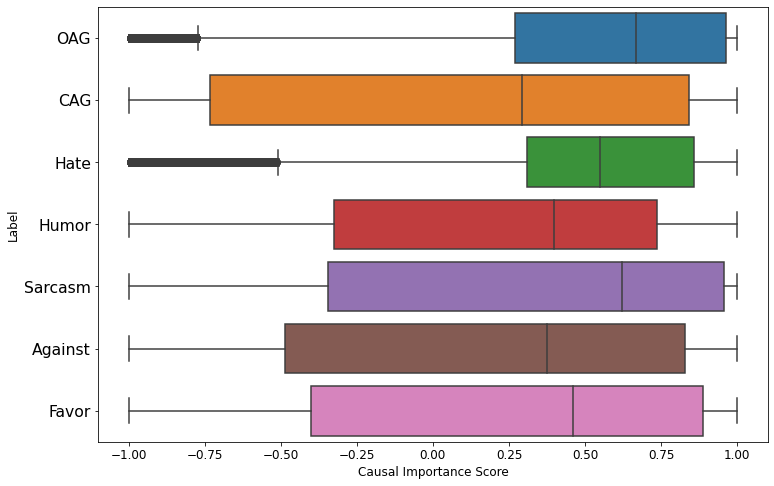

In [254]:
plt.figure(figsize=(12,8))
sns.boxplot(y="Label",x='score',data=var_tables)
#plt.xticks(rotation=45)
plt.ylabel("Label")
plt.xlabel("Causal Importance Score")

fontdict = {'fontsize': 12}

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

#plt.show()
plt.rcParams["font.family"] = 'sans-serif' #"Times New Roman"
plt.rcParams["font.size"] = "8"


#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE*1.3)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
plt.savefig('../plots/word_scores_box.pdf',dpi=200,bbox_inches='tight')
plt.show()

In [255]:
var_tables = pd.DataFrame()

temp = pd.DataFrame(words_aggression.groupby(['word'])['OAG'].var().dropna().reset_index(drop=True))
temp.columns = ['var']
temp['Label'] = "OAG"
temp["task"] = "Aggression"

var_tables = pd.concat([var_tables, temp], axis=0)

temp = pd.DataFrame(words_aggression.groupby(['word'])['CAG'].var().dropna().reset_index(drop=True))
temp.columns = ['var']
temp['Label'] = "CAG"
temp["task"] = "Aggression"

var_tables = pd.concat([var_tables, temp], axis=0)

temp = pd.DataFrame(words_hate.groupby(['word'])['Hate_yes'].var().dropna().reset_index(drop=True))
temp.columns = ['var']
temp['Label'] = "Hate"
temp['task'] = "Hate"

var_tables = pd.concat([var_tables, temp], axis=0)

temp = pd.DataFrame(words_humor.groupby(['word'])['Humor_yes'].var().dropna().reset_index(drop=True))
temp.columns = ['var']
temp['Label'] = "Humor"
temp["task"] = "Humor"

var_tables = pd.concat([var_tables, temp], axis=0)

temp = pd.DataFrame(words_sarcasm.groupby(['word'])['Sarcasm_yes'].var().dropna().reset_index(drop=True))
temp.columns = ['var']
temp['Label'] = "Sarcasm"
temp['task'] = "Sarcasm"

var_tables = pd.concat([var_tables, temp], axis=0)

temp = pd.DataFrame(words_stance.groupby(['word'])['Stance_against'].var().dropna().reset_index(drop=True))
temp.columns = ['var']
temp['Label'] = "Against"
temp["task"] = "Stance"

var_tables = pd.concat([var_tables, temp], axis=0)

temp = pd.DataFrame(words_stance.groupby(['word'])['Stance_favor'].var().dropna().reset_index(drop=True))
temp.columns = ['var']
temp['Label'] = "Favor"
temp["task"] = "Stance"

var_tables = pd.concat([var_tables, temp], axis=0)

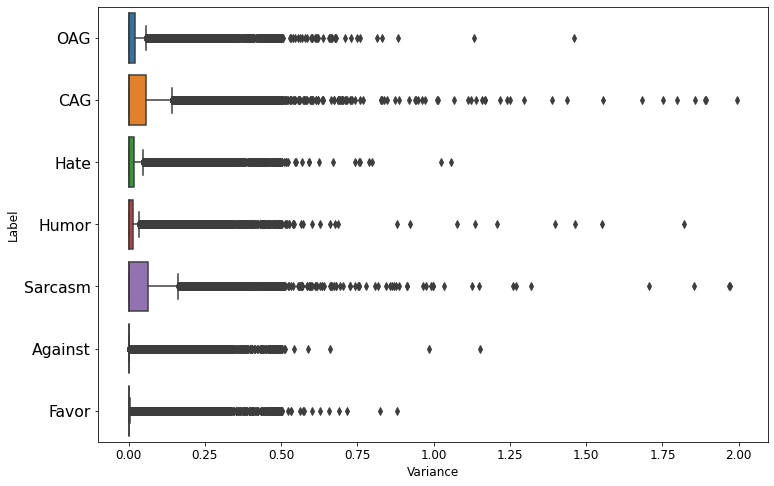

In [256]:
plt.figure(figsize=(12,8))
sns.boxplot(y="Label",x='var',data=var_tables)
#plt.xticks(rotation=45)
plt.ylabel("Label")
plt.xlabel("Variance")

fontdict = {'fontsize': 12}

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

#plt.show()
plt.rcParams["font.family"] = 'sans-serif' #"Times New Roman"
plt.rcParams["font.size"] = "8"


#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE*1.3)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
plt.savefig('../plots/word_variances.pdf',dpi=200,bbox_inches='tight')
plt.show()

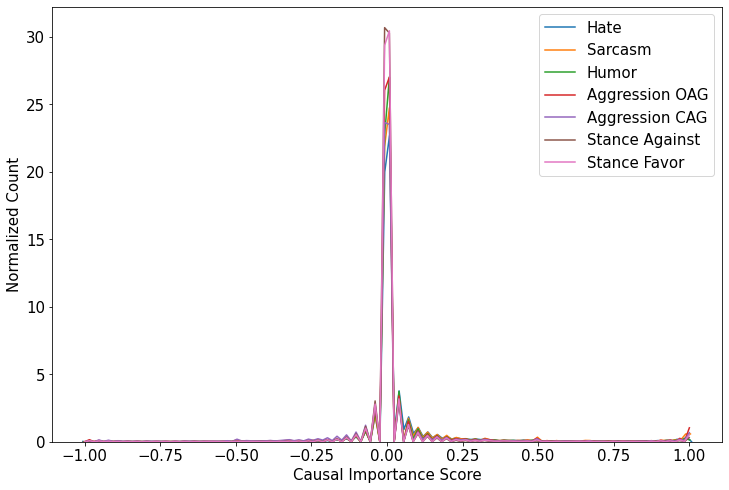

In [261]:
plt.figure(figsize=(12,8))
sns.distplot(words_hate.groupby(['word'])['Hate_yes'].mean(), hist=False, rug=False, label='Hate')
sns.distplot(words_sarcasm.groupby(['word'])['Sarcasm_yes'].mean(), hist=False, rug=False, label='Sarcasm')
sns.distplot(words_humor.groupby(['word'])['Humor_yes'].mean(), hist=False, rug=False, label='Humor')
sns.distplot(words_aggression.groupby(['word'])['OAG'].mean(), hist=False, rug=False, label='Aggression OAG')
sns.distplot(words_aggression.groupby(['word'])['CAG'].mean(), hist=False, rug=False, label='Aggression CAG')
sns.distplot(words_stance.groupby(['word'])['Stance_against'].mean(), hist=False, rug=False, label='Stance Against')
sns.distplot(words_stance.groupby(['word'])['Stance_favor'].mean(), hist=False, rug=False, label='Stance Favor')

fontdict = {'fontsize': 15}

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

#plt.show()
plt.rcParams["font.family"] = 'sans-serif' #"Times New Roman"
plt.rcParams["font.size"] = "15"


#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.ylabel("Normalized Count")
plt.xlabel("Causal Importance Score")

plt.savefig('../plots/word_scores_hist.pdf',dpi=200,bbox_inches='tight')
plt.show()

In [216]:
stats_hate = words_hate.groupby(['word'])['Hate_yes'].agg(['min','var','count']).reset_index(drop=False).dropna()
stats_hate = stats_hate[stats_hate['var'] != 0]
stats_hate['score'] = stats_hate.apply(lambda x: np.log10(x['min']/(1-x['min']))*x['count']*x['count']/np.sqrt(x['var']), axis=1)
stats_hate = stats_hate.sort_values(['score'],ascending=[False])
print (stats_hate.head(20))

/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


                 word       min           var  count          score
10982  ckt             0.993328  2.952683e-07  7      195935.036744
8398   buddhist hindu  0.999634  1.853255e-08  2      100966.487971
30451  kir             0.970238  8.437752e-08  4      83350.699996 
1757   albata          0.989664  9.191593e-08  3      58811.837964 
10876  chutiyas        0.997396  4.808035e-07  2      14901.733859 
19129  ghut            0.744313  3.835652e-07  4      11988.444329 
25779  jadojehad       0.950275  9.958754e-07  3      11555.336083 
20812  hai  i          0.924789  7.192598e-04  10     4063.392934  
31132  krskty          0.978511  4.450312e-06  2      3144.428144  
31351  kur             0.782578  1.418847e-03  13     2495.566674  
29787  khatmy          0.965650  3.750674e-05  2      946.329175   
15169  dosray          0.933089  7.668146e-04  4      661.245928   
37363  nachania        0.785413  2.140882e-04  4      616.187987   
13702  desperatley     0.979073  1.908036e-04  2

In [217]:
stats_sarcasm = words_sarcasm.groupby(['word'])['Sarcasm_yes'].agg(['min','var','count']).reset_index(drop=False).dropna()
stats_sarcasm = stats_sarcasm[stats_sarcasm['var'] != 0]
stats_sarcasm['score'] = stats_sarcasm.apply(lambda x: np.log10(x['min']/(1-x['min']))*x['count']*x['count']/np.sqrt(x['var']), axis=1)
stats_sarcasm = stats_sarcasm.sort_values(['score'],ascending=[False])
print (stats_sarcasm.head(20))

/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


                    word       min           var  count          score
35372  naadan             0.997622  6.741514e-08  4      161617.507332
27571  katrae             0.996699  2.494747e-06  4      25122.023118 
42679  ras                0.998775  5.554463e-07  2      15626.072342 
42703  rashtrahit         0.995045  5.136367e-06  3      9144.683162  
54253  wansaj             0.876913  3.419272e-07  2      5833.269665  
39454  phain              0.992999  2.331798e-06  2      5636.563587  
30789  lehrate            0.993472  1.324591e-05  3      5396.780710  
54212  walle   notebandi  0.969866  3.077344e-06  2      3437.742102  
9348   chauda             0.980916  5.697032e-05  2      906.720576   
14667  dukha              0.939702  9.693461e-04  4      612.924138   
38724  parwez             0.960331  4.355984e-04  3      596.796201   
24215  izaat              0.963164  2.250171e-04  2      377.967086   
50601  thokegi            0.939130  1.219868e-03  3      306.210258   
40867 

In [219]:
stats_aggression = words_aggression.groupby(['word'])['CAG'].agg(['min','var','count']).reset_index(drop=False).dropna()
stats_aggression = stats_aggression[stats_aggression['var'] != 0]
stats_aggression['score'] = stats_aggression.apply(lambda x: np.log10(x['min']/(1-x['min']))*x['count']*x['count']/np.sqrt(x['var']), axis=1)
stats_aggression = stats_aggression.sort_values(['score'],ascending=[False])
print (stats_aggression.head(20))

/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


                    word       min           var  count         score
40193  pattak             0.999984  6.484413e-11  4      9.505129e+06
45646  saaaf              0.999986  6.548362e-11  2      2.395551e+06
7885   bosses             0.996209  8.720716e-07  2      1.036394e+04
25241  jadojehad          0.992501  3.805986e-06  3      9.787980e+03
33189  maharaja           0.991850  3.087344e-05  2      1.501167e+03
40857  phenke             0.985383  1.028449e-04  2      7.213058e+02
4012   badao              0.978608  1.518174e-04  2      5.390150e+02
39571  panchar            0.871626  1.025741e-03  3      2.337604e+02
8018   bravehearts        0.951315  5.813541e-04  2      2.141617e+02
20314  hai   uniform      0.841087  2.667176e-03  3      1.261145e+02
48128  shath              0.803232  9.582462e-03  4      9.984872e+01
50308  sudharna           0.907171  1.783427e-03  2      9.377154e+01
1727   albata             0.523894  2.125592e-05  3      8.109052e+01
37743  nikam        

In [186]:
words_hate = words_hate.groupby(['word'])['Hate_yes'].min().reset_index(drop=False)
words_sarcasm = words_sarcasm.groupby(['word'])['Sarcasm_yes'].min().reset_index(drop=False)
words_humor = words_humor.groupby(['word'])['Humor_yes'].min().reset_index(drop=False)
words_aggression = words_aggression.groupby(['word'])['OAG','CAG'].min().reset_index(drop=False)
words_stance = words_stance.groupby(['word'])['Stance_against','Stance_favor'].min().reset_index(drop=False)

/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [87]:
words = pd.merge(words_hate,words_aggression,how='outer')
words = pd.merge(words_humor,words,how='outer')
words = pd.merge(words_sarcasm,words,how='outer')
words = pd.merge(words_stance,words,how='outer')

In [88]:
words = words.dropna()
#words.word = words.word.fillna('')
#words = words.fillna(0)

In [89]:
words.word = words.word.apply(lambda x: re.sub('[^a-zA-Z0-9]',' ',x).strip())

In [90]:
words = words[words.word != '']

In [91]:
words.sort_values(['Hate_yes'],ascending=[False]).head(20)

,word,Stance_against,Stance_favor,Sarcasm_yes,Humor_yes,Hate_yes,OAG,CAG
13551,digesting,-2.028346e-04,2.962595e-12,1.071535e-03,8.449666e-04,0.999951,-8.170481e-04,8.777101e-01
29823,kutta chara,-1.225274e-06,4.466176e-04,-2.978322e-07,1.197779e-03,0.999950,5.960464e-07,-4.723004e-07
12121,darshil,-1.390012e-10,-4.160419e-05,6.629938e-08,8.344650e-06,0.999925,-2.921717e-03,2.950966e-03
19235,haan i,-1.174101e-11,1.598080e-04,-1.063218e-07,-4.526095e-03,0.999881,2.134442e-04,-3.944617e-05
17077,g d,-8.813120e-10,-1.486980e-10,-9.198704e-01,-1.847350e-05,0.999874,9.999212e-01,-2.223383e-07
7012,bilkul bhi,-2.453871e-03,6.965078e-01,-5.149382e-07,9.958488e-01,0.999859,-1.818487e-07,9.981262e-01
35580,nahi hate,2.457888e-07,8.316037e-01,-4.155156e-09,5.025792e-02,0.999855,-1.432282e-02,8.557901e-01
55142,yeah kulbhushan,-5.256111e-07,-1.605457e-10,-3.335941e-06,1.512170e-03,0.999779,0.000000e+00,-1.002462e-16
27731,kedarnath,-7.429790e-13,8.344650e-06,1.610946e-05,5.625486e-03,0.999739,3.200485e-12,2.384186e-07
10199,chuitiye,-2.939105e-04,2.946081e-04,-2.405047e-04,9.655952e-06,0.999729,2.517815e-01,-2.499329e-01


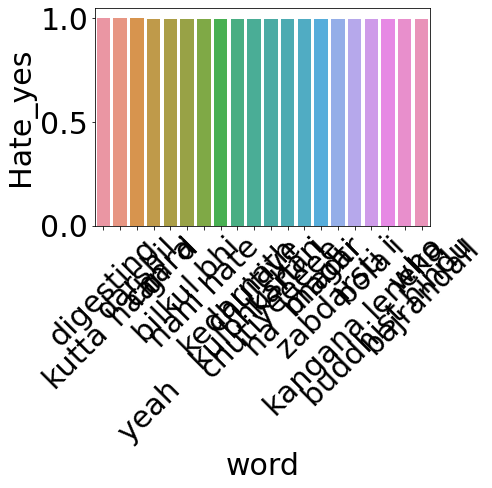

In [92]:
sns.barplot(x='word',y='Hate_yes',data=words.sort_values(['Hate_yes'],ascending=[False]).head(20))
plt.xticks(rotation=45)
plt.show()

In [93]:
words.sort_values(['OAG'],ascending=[False]).head(20)

,word,Stance_against,Stance_favor,Sarcasm_yes,Humor_yes,Hate_yes,OAG,CAG
47862,sonagacchi,-2.498765e-10,6.042377e-03,7.656651e-01,2.261448e-02,-5.742988e-04,1.0,-9.999965e-01
35918,nashukree,-3.994042e-07,4.724390e-09,-7.389100e-04,3.421307e-05,1.812205e-03,1.0,-1.000000e+00
42698,rashmidi,8.883489e-07,2.887528e-09,3.570718e-12,9.775162e-06,-4.000206e-04,1.0,-1.000000e+00
6500,bhencho khane,1.052225e-01,-4.703177e-08,3.012343e-12,-1.120281e-03,2.867149e-01,1.0,-9.999989e-01
5456,begaane,9.511222e-14,-3.279450e-10,5.254164e-01,2.069426e-02,3.079011e-04,1.0,4.427404e-10
11903,dalega,-3.851490e-06,-3.702887e-08,5.483627e-06,0.000000e+00,-2.313465e-02,1.0,-1.000000e+00
17347,gandda,2.738184e-06,4.554264e-02,9.993249e-01,2.569578e-02,9.653998e-05,1.0,-2.108788e-04
14498,draupadi,-3.912429e-10,3.756944e-11,9.970122e-01,-1.359951e-02,1.206378e-01,1.0,-1.000000e+00
17414,ganndey,-5.532884e-09,-1.992824e-06,7.892537e-08,-4.768372e-07,4.456348e-02,1.0,-9.999999e-01
7420,bokchod,4.252625e-08,2.041698e-03,1.784285e-04,-2.863969e-02,6.257189e-07,1.0,-1.153711e-07


In [94]:
words.sort_values(['CAG'],ascending=[False]).head(20)

,word,Stance_against,Stance_favor,Sarcasm_yes,Humor_yes,Hate_yes,OAG,CAG
20800,hatwao,-4.621722e-05,9.980672e-01,-1.046565e-07,0.000233,6.957251e-06,-1.172675e-08,1.0
54526,what d,-8.183812e-01,1.920379e-07,-1.929354e-07,0.990632,-3.378133e-10,-7.529674e-08,1.0
2010,anas,8.638854e-09,5.760962e-01,-2.684685e-07,0.009254,6.160356e-05,1.962587e-08,1.0
27380,karwao agar,-2.918699e-16,-3.646475e-10,-1.303234e-03,0.766125,9.992986e-01,-9.434507e-11,1.0
32823,maratha,-1.968529e-03,4.177166e-08,2.726581e-14,0.010984,-1.896487e-01,1.620433e-08,1.0
49518,talaga,1.272024e-12,-9.177291e-02,4.346886e-08,0.000001,-1.926064e-03,-1.000000e+00,1.0
38049,paidawaar,5.854342e-13,-4.296072e-07,-2.804940e-06,-0.067348,-1.724105e-04,1.372573e-10,1.0
24796,jangle,-6.049281e-07,-4.630521e-04,1.616877e-08,0.006700,1.080524e-05,1.016105e-11,1.0
50188,tha bhul,1.270603e-14,3.793629e-12,1.755787e-06,0.878022,1.984589e-03,-3.026320e-12,1.0
144,aaggg,1.010820e-07,8.137154e-05,-6.518124e-08,-0.005558,9.885900e-01,9.481721e-13,1.0


In [95]:
words.sort_values(['Humor_yes'],ascending=[False]).head(20)

,word,Stance_against,Stance_favor,Sarcasm_yes,Humor_yes,Hate_yes,OAG,CAG
6332,bhartvasi,1.708556e-11,2.019954e-07,9.514535e-01,0.999847,0.001053,1.569968e-07,0.000000e+00
36027,navaj,-3.769416e-04,-8.750338e-05,2.173781e-04,0.999843,-0.000997,1.068648e-04,9.946179e-01
26636,kaleja,4.035074e-07,-1.397222e-12,1.178980e-04,0.999793,0.035410,9.999987e-01,-9.999202e-01
20835,haven t and,-1.366113e-03,-4.148856e-01,1.331825e-05,0.999670,0.000409,0.000000e+00,3.783693e-08
49190,swaminarayan,-2.198074e-13,3.612041e-05,9.124244e-04,0.999627,0.000057,6.395489e-13,1.196785e-12
2558,apprehension,-8.344650e-07,3.888246e-07,5.404397e-12,0.999609,0.000891,-2.796388e-10,-1.432531e-08
40168,pinnarayi,1.683539e-02,3.153333e-04,8.207964e-03,0.999594,-0.000017,-9.986787e-01,9.986783e-01
26802,kangesi,-6.050773e-12,7.124124e-12,1.639593e-01,0.999567,0.006733,0.000000e+00,-8.368468e-09
44622,sahvaag,-2.485862e-09,9.463469e-01,-6.812830e-08,0.999428,-0.000002,1.099253e-02,-3.006688e-03
42800,ravi s,-1.002680e-04,1.247830e-09,1.259930e-04,0.999410,-0.000136,1.484208e-01,-6.395582e-03


In [96]:
words.sort_values(['Sarcasm_yes'],ascending=[False]).head(20)

,word,Stance_against,Stance_favor,Sarcasm_yes,Humor_yes,Hate_yes,OAG,CAG
50441,there beautiful,1.009958e-06,2.001794e-10,1.000000,6.477218e-01,9.484552e-04,1.940578e-07,6.862504e-05
20092,haiedia,-3.478246e-10,4.509911e-01,0.999999,4.326063e-02,7.488851e-03,0.000000e+00,1.026680e-10
15807,faadu,8.542681e-02,1.828547e-02,0.999999,9.553286e-03,8.072946e-08,2.051902e-06,9.999980e-01
18064,ghostly,-9.503961e-12,9.999543e-01,0.999998,2.041706e-02,6.592613e-04,9.252896e-01,-4.049243e-02
8967,chakao,-3.288275e-09,1.092898e-14,0.999997,2.596425e-07,1.251424e-04,9.999983e-01,-9.999955e-01
24728,jammeh,2.844933e-09,9.655971e-01,0.999997,1.660692e-05,-7.228851e-04,-1.315228e-01,9.999963e-01
4146,bahgawn,-6.915060e-03,4.576895e-06,0.999997,7.811920e-01,1.465335e-01,-6.465718e-04,5.661497e-01
40023,pichad,-1.007373e-01,4.254075e-05,0.999996,8.650975e-03,1.817755e-04,-2.703399e-03,2.705157e-03
45133,samru apni,-1.256163e-06,-2.221327e-10,0.999996,-1.359302e-02,2.559889e-02,-6.439325e-01,-4.871716e-04
26011,judze,1.964389e-05,2.138771e-07,0.999996,1.485934e-02,-1.366309e-05,9.207640e-08,9.999713e-01


In [97]:
words.sort_values(['Stance_against'],ascending=[False]).head(20)

,word,Stance_against,Stance_favor,Sarcasm_yes,Humor_yes,Hate_yes,OAG,CAG
3498,azdi,1.000000,-1.000000e+00,-2.421660e-04,0.278356,0.011667,-1.880014e-04,1.620507e-02
16030,fanko,1.000000,-1.270864e-08,-6.724000e-04,0.035267,-0.000718,9.653568e-04,-9.643054e-04
8062,bujhaa,1.000000,4.515497e-10,9.851276e-01,-0.000004,0.000008,3.850460e-05,-3.775027e-05
19370,hahahaah,1.000000,-1.240064e-09,3.392848e-06,-0.155855,0.015650,-1.549721e-06,1.753732e-06
39710,pic twitter com bzvffihcqk,1.000000,-5.108659e-12,-1.889270e-14,0.001065,-0.000156,5.935629e-10,2.861023e-06
6042,bhagwant,0.999999,-9.816459e-01,-9.500980e-05,-0.002465,0.000003,-7.198257e-06,2.181530e-05
16655,foaj,0.999998,-6.033534e-11,1.017822e-12,0.000031,-0.000030,5.912781e-05,-1.493664e-07
3442,ayegi ptrol,0.999998,-6.281863e-07,2.247287e-04,0.082257,0.572414,-5.994663e-05,-1.492802e-02
55012,yaayyyyeeee,0.999995,-3.037054e-09,-3.362429e-07,0.998239,0.001145,-1.092837e-02,-8.246280e-03
49430,tainshan,0.999992,-1.887466e-08,5.791468e-03,-0.007416,-0.289705,-1.001494e-03,-9.689611e-01


In [98]:
words.sort_values(['Stance_favor'],ascending=[False]).head(20)

,word,Stance_against,Stance_favor,Sarcasm_yes,Humor_yes,Hate_yes,OAG,CAG
39429,pgogo,-1.215859e-09,1.000000,-3.482317e-14,0.046908,4.159781e-05,-9.982665e-01,9.992929e-01
1970,amusing,-4.064187e-08,1.000000,-9.460330e-03,-0.000037,-1.743784e-03,-5.845071e-04,6.721020e-04
36249,nehruvian,-1.180493e-10,1.000000,2.286398e-01,0.000567,2.028421e-02,9.991288e-01,-9.991289e-01
31732,m a,-1.106094e-03,1.000000,3.576279e-07,0.000015,-3.300066e-03,-5.411931e-08,-2.614429e-09
29474,krishh,-7.061061e-06,1.000000,4.853618e-02,-0.000002,3.777676e-03,7.713566e-01,-7.713566e-01
810,accommodated,-1.955274e-12,1.000000,-9.080008e-01,0.001011,-1.253486e-04,-1.960008e-08,-4.813668e-09
34759,msst,-9.945469e-12,1.000000,5.102381e-07,0.000002,1.344645e-07,-4.629910e-03,-1.605047e-01
16637,flowing,-7.762918e-07,1.000000,5.345036e-01,0.000104,-4.877056e-03,-2.038614e-08,-8.838838e-05
55144,yeahhhhh,-6.734850e-10,1.000000,-4.793490e-08,0.005808,2.363316e-05,1.174688e-08,8.743176e-08
11567,crystal,-9.999998e-01,1.000000,-1.006201e-09,0.000398,-8.234979e-04,-4.614295e-09,-2.717311e-06


In [99]:
cols = words.columns[1:]

words[cols].corr()

,Stance_against,Stance_favor,Sarcasm_yes,Humor_yes,Hate_yes,OAG,CAG
Stance_against,1.000000,0.210241,0.254674,0.254205,0.279183,0.265289,0.279652
Stance_favor,0.210241,1.000000,0.245123,0.249733,0.252907,0.255166,0.270743
Sarcasm_yes,0.254674,0.245123,1.000000,0.259732,0.255456,0.262721,0.285965
Humor_yes,0.254205,0.249733,0.259732,1.000000,0.262147,0.268252,0.287419
Hate_yes,0.279183,0.252907,0.255456,0.262147,1.000000,0.270152,0.273603
OAG,0.265289,0.255166,0.262721,0.268252,0.270152,1.000000,-0.006310
CAG,0.279652,0.270743,0.285965,0.287419,0.273603,-0.006310,1.000000


In [100]:
for col1 in cols:
    for col2 in cols:
        if col1 != col2:
            print (col1, col2, ttest_ind(words[col1],words[col2]).pvalue)

Stance_against Stance_favor 1.0073032451961136e-16
Stance_against Sarcasm_yes 8.371584416335339e-07
Stance_against Humor_yes 2.569234932520798e-57
Stance_against Hate_yes 5.99521122229457e-143
Stance_against OAG 4.397086914943397e-31
Stance_against CAG 1.7955032007503025e-266
Stance_favor Stance_against 1.0073032451961136e-16
Stance_favor Sarcasm_yes 2.9916559271140285e-29
Stance_favor Humor_yes 2.8338906837559302e-14
Stance_favor Hate_yes 2.046763040137375e-64
Stance_favor OAG 2.7494913134179962e-05
Stance_favor CAG 0.0
Sarcasm_yes Stance_against 8.371584416335339e-07
Sarcasm_yes Stance_favor 2.9916559271140285e-29
Sarcasm_yes Humor_yes 9.577768451751737e-66
Sarcasm_yes Hate_yes 3.022532337868542e-132
Sarcasm_yes OAG 1.827559413750925e-43
Sarcasm_yes CAG 1.1067999237573952e-144
Humor_yes Stance_against 2.569234932520798e-57
Humor_yes Stance_favor 2.8338906837559302e-14
Humor_yes Sarcasm_yes 9.577768451751737e-66
Humor_yes Hate_yes 2.1793625304687358e-20
Humor_yes OAG 0.008906146967712

In [280]:
aggression_test[aggression_test.type == 'hate'][aggression_test.category == 'yes'][aggression_test.category_predicted_model2 == 'OAG'].tail(20)

/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,text,category,type,category_predicted_model1,category_prob_model1,category_predicted_model2,category_prob_model2
371,"tumhare to terrorism failane aate hain, indian army hooron se mila deti unko",yes,hate,CAG,0.630561,OAG,0.999888
375,isko sahe nikala ghar se iscey ki awam ne . india hate arshi khan,yes,hate,OAG,0.999927,OAG,1.000000
377,"apne national anthem ko change karo and yeh line add karo “chutiyeh zammen shaban, terristo ka yeh jahan” terrorism itna phela hai ke koi company porkistan mei. aatie nahi, sirf terrorist aate hai osama jaise",yes,hate,OAG,1.000000,OAG,1.000000
380,kute apni asli zaat dikhane lage gujarat jit gaye hae hindustan ki ladkio sambhal k rehna in logo k jitne guru h rape murder cases mae shamil h to chelo ka kya guru jail mae chele guruo k kaam ko nahi chodege k chodege bus yehi hoga,yes,hate,OAG,0.949047,OAG,0.922363
381,"abe hat sali jhut bol bolkr ki dil saf h, shilpa ka use kiya, khud flip hui bitch, shilpa ki ek adat esko pasand nahi ayi hogi hume tu puri pasand nahi ayi entertaining kha se lagti thi tu,jail ja sali teri jagah hi wo h dusro pr kichad uchala tu khud hai .we hate you arshi khan",yes,hate,OAG,0.893279,OAG,0.993233
384,"u,gud people?are sharam karo. itna dam hai to sare up se sare rapust ko pakro or ek bhi rape hone se roko. magar nahi tumhe soft target chahie.",yes,hate,OAG,0.993164,OAG,1.000000
391,loray sab report hota hai yaha yeh india nahi hai k rape karo aur maar k gaar do ... yaha bc hum bachi char takk nahi sakte warna police hamara rape kar dete hain loray,yes,hate,OAG,0.999998,OAG,1.000000
400,i hate prince the most. kahi dikh gaya to jootee maar maar ke uska sada hua muh kharab krdunga jis muh se harr ladki ko kiss deta firta h.,yes,hate,CAG,0.575457,OAG,0.999152
407,i hate you raju srivastava.tumhara kya bigada hai shilpa ne.paise lekar kuch bhi karoge kya bhagwan ne tumhe bhi beti di hai.upar wala sab dekh raha hai usse daro,yes,hate,OAG,0.927209,OAG,1.000000
408,haan islam sirf sharaab peene se hi badnaam hota hai ...terrorism aur fundamentalism wahabism and salafism se nahin ...nahin ? zyadatar mughal badshah aur sultans bewre the zinko islami apna masiha maante hain ...,yes,hate,NAG,0.724254,OAG,0.982428


In [295]:
#aggression_test[aggression_test.type == 'humor'].reset_index(drop=True).iloc[4614]
aggression_test.iloc[413]

text                         i hate takla's all raps. woh muh kholta hai ki usse khuch phek ke marne ka mann karta hai
category                     yes                                                                                      
type                         hate                                                                                     
category_predicted_model1    OAG                                                                                      
category_prob_model1         0.999987                                                                                 
category_predicted_model2    OAG                                                                                      
category_prob_model2         1                                                                                        
Name: 413, dtype: object

In [296]:
#hate_test[hate_test.type == 'sarcasm'].reset_index(drop=True).iloc[322]
hate_test.iloc[413]

text                         i hate takla's all raps. woh muh kholta hai ki usse khuch phek ke marne ka mann karta hai
category                     yes                                                                                      
type                         hate                                                                                     
category_predicted_model1    yes                                                                                      
category_prob_model1         0.999994                                                                                 
category_predicted_model2    yes                                                                                      
category_prob_model2         0.999976                                                                                 
Name: 413, dtype: object

In [297]:
#sarcasm_test[sarcasm_test.type == 'sarcasm'].reset_index(drop=True).iloc[322]
sarcasm_test.iloc[413]

text                         i hate takla's all raps. woh muh kholta hai ki usse khuch phek ke marne ka mann karta hai
category                     yes                                                                                      
type                         hate                                                                                     
category_predicted_model1    NO                                                                                       
category_prob_model1         0.818405                                                                                 
category_predicted_model2    YES                                                                                      
category_prob_model2         0.78301                                                                                  
Name: 413, dtype: object

In [298]:
#humor_test[humor_test.type == 'sarcasm'].reset_index(drop=True).iloc[322]
humor_test.iloc[413]

text                         i hate takla's all raps. woh muh kholta hai ki usse khuch phek ke marne ka mann karta hai
category                     yes                                                                                      
type                         hate                                                                                     
category_predicted_model1    H                                                                                        
category_prob_model1         0.999999                                                                                 
category_predicted_model2    H                                                                                        
category_prob_model2         1                                                                                        
Name: 413, dtype: object

In [299]:
#stance_test[stance_test.type == 'sarcasm'].reset_index(drop=True).iloc[322]
stance_test.iloc[413]

text                         i hate takla's all raps. woh muh kholta hai ki usse khuch phek ke marne ka mann karta hai
category                     yes                                                                                      
type                         hate                                                                                     
category_predicted_model1    FAVOR                                                                                    
category_prob_model1         0.999988                                                                                 
category_predicted_model2    FAVOR                                                                                    
category_prob_model2         0.999995                                                                                 
Name: 413, dtype: object

In [267]:
aggression_test.tail(20)

,text,category,type,category_predicted_model1,category_prob_model1,category_predicted_model2,category_prob_model2
4614,"ab maan leya ghus k maarna yahi hota hein,, kashmir ka badla hein ar letey rahengey",CAG,aggression,OAG,1.000000,OAG,0.999147
4615,"इंच का सीना वाला घूसखोर हो गया है जो पता नहीं कितने सैनिको को शहीद करवाएगा\nयही ोदी है ,भक्तों जो ूपीए सरकार के समय जब हमारे जवानों को पाक सर काट ले गया था तो घड़ियाल का आंसू रोया था । अब तो इसकी आवाज ही् नहीं निकलती और निकलती भी है तो क्या? संवेदना...........\nभाइयो एवं बहनो ोदी_हटाओ_सेना_बचाओ\nपांच महीने में हमारे जवानों के शवों का अपमान करने का यह दूसरा मामला है। इससे पहले नवंबर में माछिल सेक्टर में तीन जवान शहीद हो गए थे। तब एक जवान का शव क्षत-विक्षत हालत में मिला था",OAG,aggression,OAG,0.999919,OAG,1.000000
4616,chalo shukaar ab un ko saraai hoyai daal nai kanai parai gi😂😂😂😂,CAG,aggression,CAG,1.000000,CAG,1.000000
4617,भाई हमको दूसरे देशो को देख क्र नही चलना,NAG,aggression,NAG,0.999999,NAG,0.999942
4618,chor hai sale petrol pump malik sarkar ko dushara vikalp bhi rakhana jaruri,OAG,aggression,OAG,0.985272,OAG,0.999385
4619,congress ki bjh se azadi se rh rhe ni to talve chat rhe hote angrejo k,CAG,aggression,CAG,0.936495,CAG,1.000000
4620,china ke bare me tumhara kya khaya hai,CAG,aggression,CAG,0.999395,CAG,1.000000
4621,apni naakaami chupane k li hamesha raashtrawaad ka sahaara lena galat h ...? ise ugr raashrtawaad kehte hai,CAG,aggression,CAG,0.999996,CAG,0.999999
4622,modi k mantroi ko lipstick or churia pahenake juta marna chahia ! sale haramkhor party !,CAG,aggression,CAG,0.999872,CAG,0.999999
4623,"sadia khan - jab tumhari koi besati karta he, tab bhi tumhe samaj nahi atta, bade cheap ho tum.",CAG,aggression,CAG,0.985638,CAG,0.999977


In [277]:
hate_test[hate_test.type == 'hate'].reset_index(drop=True).iloc[452]

text                         dalit ladki ka rape kiya tere bhai ne  ??://twitter.com/biharetv/status/ …
category                     yes                                                                       
type                         hate                                                                      
category_predicted_model1    yes                                                                       
category_prob_model1         0.999124                                                                  
category_predicted_model2    yes                                                                       
category_prob_model2         0.999617                                                                  
Name: 452, dtype: object

In [273]:
hate_test[hate_test.type == 'hate'].tail(20)

,text,category,type,category_predicted_model1,category_prob_model1,category_predicted_model2,category_prob_model2
438,ye log babaon ke rape-jihad k khilaf kyon nahin kucchh karte hain . ye baba bahno ko apne hawash ka shikar bana rahe hai jo few neutral media reporting ki wajah se ek- karke jail ja rahe hain. ://twitter.com/thewire_in/status/ …,no,hate,no,1.000000,no,0.997433
439,lala kal ke baud se zinda ghar wapis aye ho na bagair rape hue?,no,hate,no,1.000000,no,0.997666
440,koi bat niiii ap k hate ko dekhta,no,hate,no,1.000000,no,1.000000
441,atleast tumhare journalism ke gold standard ki tarah apne bhai ke rape ko toh nahi chupatey,no,hate,no,1.000000,no,0.999973
442,"hate kisi say bhi nahi tha, sab say pyar tha wo bhi bht zyada and ab nafrat hai apnay aap say isi wajah say k q tha aisa",yes,hate,no,0.999997,no,0.933516
443,nahi mujhe i hate u likhna tha,yes,hate,yes,1.000000,yes,0.997712
444,haan bhai rape toh nai hua aaj koi. par bomb toh pahte tere pakistan mein . chal bhai jab tak zinda hai twitter karle,no,hate,no,1.000000,no,0.955969
445,waise rape se mujhe teri maa ki hai allah hai yaad hai,no,hate,no,0.999947,no,0.997581
446,tu hamari fd ki jotish hai bahena and sacchi mein i hate neha,no,hate,no,1.000000,no,0.999620
447,bhai hate n hater ki baat nahi.. main toh fact bol raha. mujhe unlogo se koi lena dena nahi,no,hate,no,0.999999,no,0.999821


In [268]:
hate_test.tail(20)

,text,category,type,category_predicted_model1,category_prob_model1,category_predicted_model2,category_prob_model2
4614,"ab maan leya ghus k maarna yahi hota hein,, kashmir ka badla hein ar letey rahengey",CAG,aggression,no,0.999976,no,0.930632
4615,"इंच का सीना वाला घूसखोर हो गया है जो पता नहीं कितने सैनिको को शहीद करवाएगा\nयही ोदी है ,भक्तों जो ूपीए सरकार के समय जब हमारे जवानों को पाक सर काट ले गया था तो घड़ियाल का आंसू रोया था । अब तो इसकी आवाज ही् नहीं निकलती और निकलती भी है तो क्या? संवेदना...........\nभाइयो एवं बहनो ोदी_हटाओ_सेना_बचाओ\nपांच महीने में हमारे जवानों के शवों का अपमान करने का यह दूसरा मामला है। इससे पहले नवंबर में माछिल सेक्टर में तीन जवान शहीद हो गए थे। तब एक जवान का शव क्षत-विक्षत हालत में मिला था",OAG,aggression,no,0.999296,no,0.999973
4616,chalo shukaar ab un ko saraai hoyai daal nai kanai parai gi😂😂😂😂,CAG,aggression,no,0.998374,no,0.999235
4617,भाई हमको दूसरे देशो को देख क्र नही चलना,NAG,aggression,no,0.999997,no,1.000000
4618,chor hai sale petrol pump malik sarkar ko dushara vikalp bhi rakhana jaruri,OAG,aggression,no,0.998470,no,0.995224
4619,congress ki bjh se azadi se rh rhe ni to talve chat rhe hote angrejo k,CAG,aggression,no,0.999998,no,0.999902
4620,china ke bare me tumhara kya khaya hai,CAG,aggression,no,1.000000,no,0.999837
4621,apni naakaami chupane k li hamesha raashtrawaad ka sahaara lena galat h ...? ise ugr raashrtawaad kehte hai,CAG,aggression,yes,0.966413,yes,0.939868
4622,modi k mantroi ko lipstick or churia pahenake juta marna chahia ! sale haramkhor party !,CAG,aggression,no,0.999971,no,0.964359
4623,"sadia khan - jab tumhari koi besati karta he, tab bhi tumhe samaj nahi atta, bade cheap ho tum.",CAG,aggression,yes,0.958267,yes,0.999190


In [278]:
sarcasm_test[sarcasm_test.type == 'hate'].reset_index(drop=True).iloc[452]

text                         dalit ladki ka rape kiya tere bhai ne  ??://twitter.com/biharetv/status/ …
category                     yes                                                                       
type                         hate                                                                      
category_predicted_model1    NO                                                                        
category_prob_model1         0.999999                                                                  
category_predicted_model2    NO                                                                        
category_prob_model2         0.999999                                                                  
Name: 452, dtype: object

In [269]:
sarcasm_test.tail(20)

,text,category,type,category_predicted_model1,category_prob_model1,category_predicted_model2,category_prob_model2
4614,"ab maan leya ghus k maarna yahi hota hein,, kashmir ka badla hein ar letey rahengey",CAG,aggression,YES,0.999996,YES,1.000000
4615,"इंच का सीना वाला घूसखोर हो गया है जो पता नहीं कितने सैनिको को शहीद करवाएगा\nयही ोदी है ,भक्तों जो ूपीए सरकार के समय जब हमारे जवानों को पाक सर काट ले गया था तो घड़ियाल का आंसू रोया था । अब तो इसकी आवाज ही् नहीं निकलती और निकलती भी है तो क्या? संवेदना...........\nभाइयो एवं बहनो ोदी_हटाओ_सेना_बचाओ\nपांच महीने में हमारे जवानों के शवों का अपमान करने का यह दूसरा मामला है। इससे पहले नवंबर में माछिल सेक्टर में तीन जवान शहीद हो गए थे। तब एक जवान का शव क्षत-विक्षत हालत में मिला था",OAG,aggression,NO,0.612182,NO,0.876604
4616,chalo shukaar ab un ko saraai hoyai daal nai kanai parai gi😂😂😂😂,CAG,aggression,YES,0.999993,YES,1.000000
4617,भाई हमको दूसरे देशो को देख क्र नही चलना,NAG,aggression,NO,0.996994,NO,1.000000
4618,chor hai sale petrol pump malik sarkar ko dushara vikalp bhi rakhana jaruri,OAG,aggression,YES,0.978145,YES,0.999977
4619,congress ki bjh se azadi se rh rhe ni to talve chat rhe hote angrejo k,CAG,aggression,NO,1.000000,NO,1.000000
4620,china ke bare me tumhara kya khaya hai,CAG,aggression,NO,0.999094,NO,0.999360
4621,apni naakaami chupane k li hamesha raashtrawaad ka sahaara lena galat h ...? ise ugr raashrtawaad kehte hai,CAG,aggression,YES,0.953597,YES,0.999917
4622,modi k mantroi ko lipstick or churia pahenake juta marna chahia ! sale haramkhor party !,CAG,aggression,NO,0.994780,NO,0.999993
4623,"sadia khan - jab tumhari koi besati karta he, tab bhi tumhe samaj nahi atta, bade cheap ho tum.",CAG,aggression,YES,0.998825,YES,0.999394


In [270]:
humor_test.tail(20)

,text,category,type,category_predicted_model1,category_prob_model1,category_predicted_model2,category_prob_model2
4614,"ab maan leya ghus k maarna yahi hota hein,, kashmir ka badla hein ar letey rahengey",CAG,aggression,H,0.999048,H,0.998395
4615,"इंच का सीना वाला घूसखोर हो गया है जो पता नहीं कितने सैनिको को शहीद करवाएगा\nयही ोदी है ,भक्तों जो ूपीए सरकार के समय जब हमारे जवानों को पाक सर काट ले गया था तो घड़ियाल का आंसू रोया था । अब तो इसकी आवाज ही् नहीं निकलती और निकलती भी है तो क्या? संवेदना...........\nभाइयो एवं बहनो ोदी_हटाओ_सेना_बचाओ\nपांच महीने में हमारे जवानों के शवों का अपमान करने का यह दूसरा मामला है। इससे पहले नवंबर में माछिल सेक्टर में तीन जवान शहीद हो गए थे। तब एक जवान का शव क्षत-विक्षत हालत में मिला था",OAG,aggression,N,1.000000,N,0.999457
4616,chalo shukaar ab un ko saraai hoyai daal nai kanai parai gi😂😂😂😂,CAG,aggression,N,0.999933,N,0.684668
4617,भाई हमको दूसरे देशो को देख क्र नही चलना,NAG,aggression,N,1.000000,N,0.999902
4618,chor hai sale petrol pump malik sarkar ko dushara vikalp bhi rakhana jaruri,OAG,aggression,N,0.999472,N,0.975205
4619,congress ki bjh se azadi se rh rhe ni to talve chat rhe hote angrejo k,CAG,aggression,N,0.997805,N,0.993843
4620,china ke bare me tumhara kya khaya hai,CAG,aggression,N,0.999997,N,0.998754
4621,apni naakaami chupane k li hamesha raashtrawaad ka sahaara lena galat h ...? ise ugr raashrtawaad kehte hai,CAG,aggression,H,1.000000,H,0.994595
4622,modi k mantroi ko lipstick or churia pahenake juta marna chahia ! sale haramkhor party !,CAG,aggression,H,1.000000,H,0.999996
4623,"sadia khan - jab tumhari koi besati karta he, tab bhi tumhe samaj nahi atta, bade cheap ho tum.",CAG,aggression,H,1.000000,H,1.000000


In [271]:
stance_test.tail(20)

,text,category,type,category_predicted_model1,category_prob_model1,category_predicted_model2,category_prob_model2
4614,"ab maan leya ghus k maarna yahi hota hein,, kashmir ka badla hein ar letey rahengey",CAG,aggression,NONE,0.952554,NONE,0.999999
4615,"इंच का सीना वाला घूसखोर हो गया है जो पता नहीं कितने सैनिको को शहीद करवाएगा\nयही ोदी है ,भक्तों जो ूपीए सरकार के समय जब हमारे जवानों को पाक सर काट ले गया था तो घड़ियाल का आंसू रोया था । अब तो इसकी आवाज ही् नहीं निकलती और निकलती भी है तो क्या? संवेदना...........\nभाइयो एवं बहनो ोदी_हटाओ_सेना_बचाओ\nपांच महीने में हमारे जवानों के शवों का अपमान करने का यह दूसरा मामला है। इससे पहले नवंबर में माछिल सेक्टर में तीन जवान शहीद हो गए थे। तब एक जवान का शव क्षत-विक्षत हालत में मिला था",OAG,aggression,NONE,1.000000,NONE,1.000000
4616,chalo shukaar ab un ko saraai hoyai daal nai kanai parai gi😂😂😂😂,CAG,aggression,NONE,1.000000,NONE,1.000000
4617,भाई हमको दूसरे देशो को देख क्र नही चलना,NAG,aggression,NONE,1.000000,NONE,1.000000
4618,chor hai sale petrol pump malik sarkar ko dushara vikalp bhi rakhana jaruri,OAG,aggression,FAVOR,1.000000,FAVOR,0.999710
4619,congress ki bjh se azadi se rh rhe ni to talve chat rhe hote angrejo k,CAG,aggression,NONE,0.999995,NONE,1.000000
4620,china ke bare me tumhara kya khaya hai,CAG,aggression,NONE,1.000000,NONE,1.000000
4621,apni naakaami chupane k li hamesha raashtrawaad ka sahaara lena galat h ...? ise ugr raashrtawaad kehte hai,CAG,aggression,NONE,0.999958,NONE,0.999997
4622,modi k mantroi ko lipstick or churia pahenake juta marna chahia ! sale haramkhor party !,CAG,aggression,FAVOR,0.989600,FAVOR,1.000000
4623,"sadia khan - jab tumhari koi besati karta he, tab bhi tumhe samaj nahi atta, bade cheap ho tum.",CAG,aggression,NONE,0.994353,NONE,0.999989
